In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.metrics import confusion_matrix


In [3]:
# Load and View Data
# Read Files
file_path = "/Users/Owner/amazon_cells_labelled.txt"
amazon = pd.read_csv(file_path, delimiter='\t', header=None,  names=['review', 'rating'])
amazon

,review,rating
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


In [4]:
file_path = "/Users/Owner/yelp_labelled.txt"
yelp = pd.read_csv(file_path, delimiter='\t', header=None,  names=['review', 'rating'])
yelp

,review,rating
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [5]:
file_path = "/Users/Owner/imdb_labelled.txt"
imdb = pd.read_csv(file_path, delimiter='\t', header=None, names=['review', 'rating'], quoting=3)
imdb

,review,rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
995,I just got bored watching Jessice Lange take h...,0
996,"Unfortunately, any virtue in this film's produ...",0
997,"In a word, it is embarrassing.",0
998,Exceptionally bad!,0


In [6]:
# Concat
df = pd.concat((yelp, imdb, amazon), ignore_index=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3000 non-null   object
 1   rating  3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [8]:
df.shape

(3000, 2)

In [9]:
# Check for missing data
df.isnull().sum()

review    0
rating    0
dtype: int64

In [10]:
# Drop NAs
df.dropna()

,review,rating
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
2995,The screen does get smudged easily because it ...,0
2996,What a piece of junk.. I lose more calls on th...,0
2997,Item Does Not Match Picture.,0
2998,The only thing that disappoint me is the infra...,0


In [11]:
# Presence of unusual characters (course materials, n.d.)     B1a
unusual = df['review']
list_of_chars = []
for uchars in unusual:
    for char in uchars:
        if char not in list_of_chars:
            list_of_chars.append(char)
print(list_of_chars)

['W', 'o', 'w', '.', ' ', 'L', 'v', 'e', 'd', 't', 'h', 'i', 's', 'p', 'l', 'a', 'c', 'C', 'r', 'u', 'n', 'g', 'N', 'y', 'x', 'j', 'S', 'b', 'M', 'k', 'f', 'R', 'm', 'T', 'I', 'H', "'", 'A', ')', ',', '!', 'V', 'B', 'z', '-', '4', 'O', '2', '3', 'q', 'P', 'F', 'G', '5', '1', '0', 'E', 'Z', 'D', 'U', 'J', 'Y', 'K', '&', 'é', ':', ';', '9', '7', '(', 'X', '"', '/', '8', 'Q', '$', '%', '+', '*', '?', '6', 'ê', '\x96', '\x85', 'å', '\x97', '#', '[', ']']


In [12]:
# Cleaning up data via loop
information_list=[]
stop_words = stopwords.words('english')

for information in df.review:
    # Remove punctuation
    information = re.sub("[^a-zA-Z]", " ", information)
    # Lowercase
    information = information.lower()
    # Tokenize     B2
    information=nltk.word_tokenize(information)
    # Lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    information = [lemmatizer.lemmatize(word) for word in information]
    # Remove stop words
    information = [word for word in information if not word in stop_words]
    information = " ".join(information)
    information_list.append(information)

In [13]:
# Identify Vocabulary size     B1b
vocabulary_size = Tokenizer()
vocabulary_size.fit_on_texts(df['review'])
print('Size of Vocabulary: ', 1+len(vocabulary_size.word_index))

Size of Vocabulary:  5272


In [14]:
# Proposed word embedding length     B1c
size_of_vocab = 1+len(vocabulary_size.word_index)
embedding_value = int(np.sqrt(np.sqrt(size_of_vocab)))
print('Word Embedding Length: ', embedding_value)
embedding_value= embedding_value*4

Word Embedding Length:  8


In [15]:
# Statistical justification for the chosen maximum sequence length      B1d

In [16]:
# Determine min, med, and max lengths of reviews
length_measures = []
for length in df.review:
    length_measures.append(len(length.split(" ")))


rmax = np.max(length_measures)
rmedian = np.median(length_measures)
rmin = np.min(length_measures)
print('Max length: ', rmax)
print('Median length: ', rmedian)
print('Min length: ', rmin)

Max length:  73
Median length:  11.0
Min length:  1


In [17]:
# Number of categories of sentiment    B4

In [18]:
# Examine ratings distribution
df['rating'].value_counts()

rating
1    1500
0    1500
Name: count, dtype: int64

<Axes: xlabel='rating', ylabel='count'>

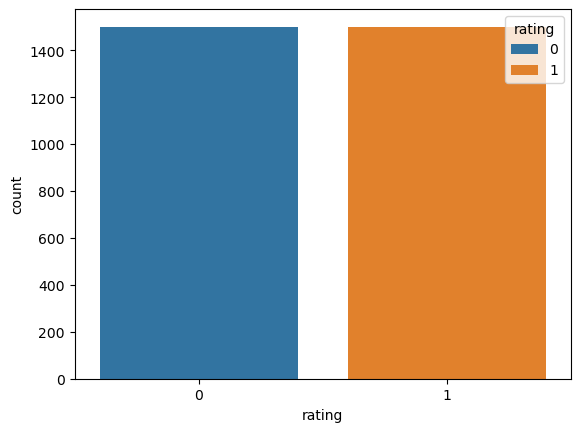

In [19]:
# Plot rating
seaborn.countplot(x='rating', data=df, hue='rating')

In [20]:
# Split Data Set
X = np.array(information_list)
y = df.rating.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [21]:
X_train.shape


(2400,)

In [22]:
X_test.shape

(600,)

In [23]:
# Padding    B3

In [24]:
# Apply padding to training and testing data
training_sequences = vocabulary_size.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, padding='post')

testing_sequences = vocabulary_size.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, padding='post')

In [25]:
# Display padded sequence for rubric
training_padded[12]

array([ 380,  269,   35, 2544,  351,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [26]:
# Convert to np.array
training_padded = np.array(training_padded)
training_label = np.array(y_train)
test_padded = np.array(testing_padded)
test_label = np.array(y_test)

In [27]:
# Save Data Sets    B6

In [28]:
pd.DataFrame(training_padded).to_csv('training_padded.csv')
pd.DataFrame(training_label).to_csv('training_label.csv')
pd.DataFrame(test_padded).to_csv('test_padded.csv')
pd.DataFrame(test_label).to_csv('test_label.csv')

In [29]:
# Build, compile, summary(), fit the model

In [30]:
# Sequential model and compile
model = Sequential()
model.add(Embedding(size_of_vocab, embedding_value, input_shape=(training_padded.shape[1],)))
model.add(SpatialDropout1D(.2))
model.add(LSTM(units=60, activation='tanh', recurrent_dropout=.4))
model.add(Dense(units=20, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# Model Summary     C1
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 32)         │       168,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 40, 32)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60)             │        22,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         1,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,265 (751.04 KB)

 Trainable params: 192,265 (751.04 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Fit model
early_stopping_monitor = EarlyStopping(patience=6)
history = model.fit(training_padded, training_label, epochs=30, batch_size=32, validation_data=(test_padded, test_label), callbacks=early_stopping_monitor)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4936 - loss: 0.6955 - val_accuracy: 0.4917 - val_loss: 0.6933
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4741 - loss: 0.6939 - val_accuracy: 0.4917 - val_loss: 0.6934
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4887 - loss: 0.6937 - val_accuracy: 0.5050 - val_loss: 0.6932
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4938 - loss: 0.6939 - val_accuracy: 0.4950 - val_loss: 0.6937
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5045 - loss: 0.6939 - val_accuracy: 0.5050 - val_loss: 0.6931
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5182 - loss: 0.6930 - val_accuracy: 0.4950 - val_loss: 0.6942
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5279 - loss: 0.6925 - val_accuracy: 0.5050 - val_loss: 0.6933
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4982 - loss: 0.6935 - val_accuracy: 0.5050 - v

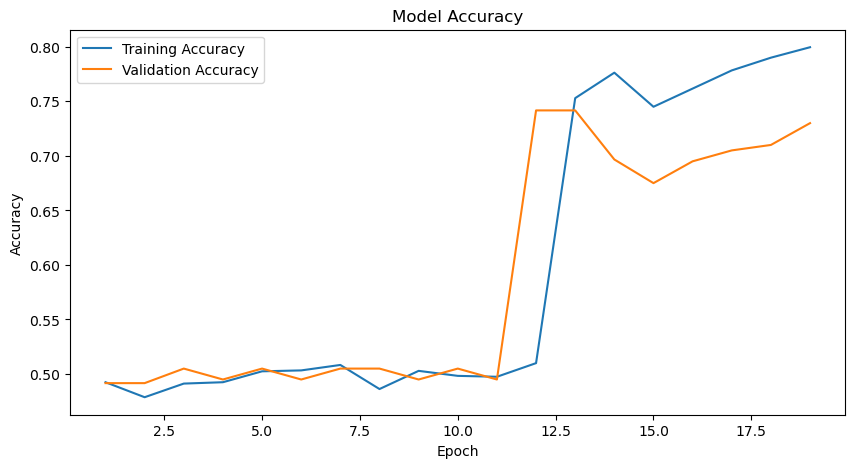

In [33]:
# Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label="Validation Accuracy")
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

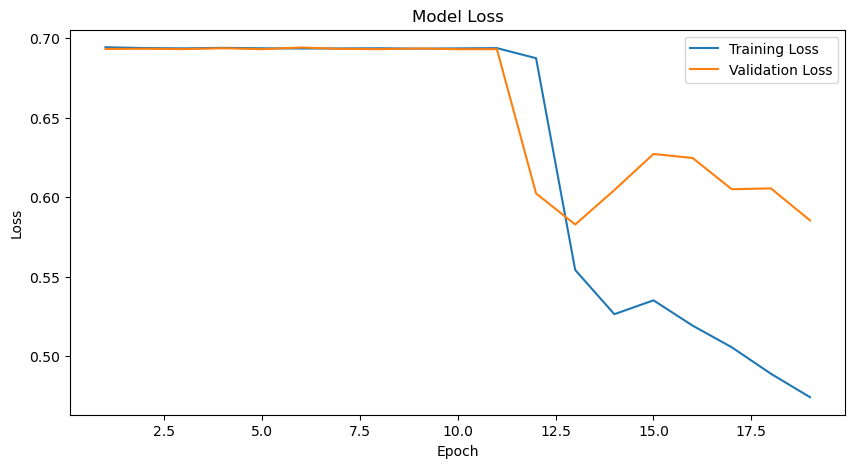

In [34]:
# Loss plot
plt.figure(figsize=(10,5))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label='Training Loss')
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="Validation Loss")
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# Evaluate the model
res = model.evaluate(test_padded, test_label, verbose=0)
print('Test Loss: ', res[0])
print('Test Accuracy: ', res[1])

Test Loss:  0.585349977016449
Test Accuracy:  0.7300000190734863


In [36]:
res = model.evaluate(training_padded, training_label, verbose=0)
print('Training Loss: ', res[0])
print('Training Accuracy: ', res[1])

Training Loss:  0.4551444351673126
Training Accuracy:  0.815833330154419


In [37]:
# Confusion Matrix for prediction

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


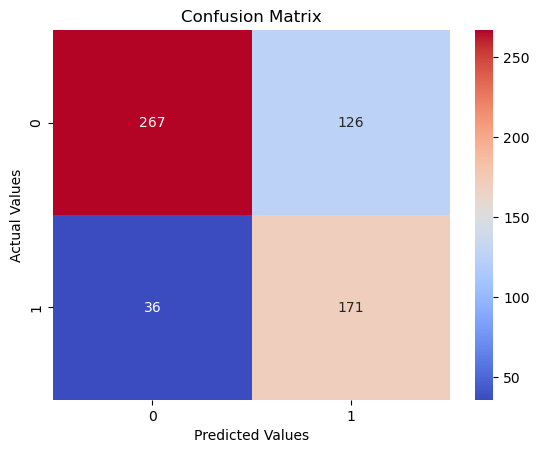

In [38]:
predictions = model.predict(test_padded)
predictions = np.round(predictions, 0).astype(int)

cm = confusion_matrix(predictions, test_label)
seaborn.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [39]:
# Save model
model.save('d213task2model.keras')

In [40]:
# Model.save, make recommendations, include sources at end